<a href="https://colab.research.google.com/github/GinuraAdikari/InsightHive/blob/Recommendation_Engine/PyG_Han.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns


import os

In [ ]:
# Load the events data
event_df=pd.read_csv('events.csv')
event_df

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN
...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,NaN
2756097,1438399813142,762376,view,115946,NaN
2756098,1438397820527,1251746,view,78144,NaN
2756099,1438398530703,1184451,view,283392,NaN


In [ ]:
# Load the category tree data
category_tree=pd.read_csv('category_tree.csv')

category_tree.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [ ]:
# load item-related datasets
item1=pd.read_csv('item_properties_part1.csv')
item2=pd.read_csv('item_properties_part2.csv')

# Combine the item properties dataframes
item_properties = pd.concat([item1, item2])
item_properties.head(10)

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513
5,1436065200000,285026,available,0
6,1434250800000,89534,213,1121373
7,1431831600000,264312,6,319724
8,1433646000000,229370,202,1330310
9,1434250800000,98113,451,1141052 n48.000


In [ ]:
# Filter for items with at least 'categoryid' OR 'availability'
filtered_items = item_properties[item_properties['property'].isin(['categoryid', 'available'])]

filtered_items.shape

(2291853, 4)

In [ ]:
duplicates = filtered_items[filtered_items.duplicated(subset=['itemid', 'property', 'value'], keep=False)]
print(duplicates)
print(f"Number of duplicate rows: {len(duplicates)}")

             timestamp  itemid    property value
5        1436065200000  285026   available     0
15       1437274800000  186518   available     0
82       1434250800000  316253   available     1
96       1437274800000  430459   available     0
101      1433041200000  411262   available     0
...                ...     ...         ...   ...
9275856  1438484400000  225378   available     1
9275873  1435460400000  444741  categoryid   511
9275879  1435460400000   97513  categoryid  1385
9275892  1439089200000  200211   available     0
9275897  1436065200000   74745   available     0

[1534714 rows x 4 columns]
Number of duplicate rows: 1534714


In [ ]:
# Convert 'value' column in filtered_items to int64 using .loc
filtered_items.loc[:, 'value'] = pd.to_numeric(filtered_items['value'], errors='coerce').astype('Int64')

# Now perform the merge
items_cats = pd.merge(filtered_items, category_tree, how='left', left_on='value', right_on='categoryid')
items_cats

,timestamp,itemid,property,value,categoryid,parentid
0,1435460400000,460429,categoryid,1338,1338.0,1278.0
1,1436065200000,285026,available,0,0.0,605.0
2,1437274800000,186518,available,0,0.0,605.0
3,1433646000000,423682,available,0,0.0,605.0
4,1434250800000,316253,available,1,1.0,854.0
...,...,...,...,...,...,...
2291848,1435460400000,444741,categoryid,511,511.0,724.0
2291849,1435460400000,97513,categoryid,1385,1385.0,1202.0
2291850,1433041200000,356167,available,0,0.0,605.0
2291851,1439089200000,200211,available,0,0.0,605.0


In [ ]:
items_cats['categoryid'] = items_cats['categoryid'].fillna('Unknown')
items_cats['parentid'] = items_cats['parentid'].fillna('Unknown')

In [ ]:
# Sort by itemid and timestamp
items_cats_sorted = items_cats.sort_values(by=['itemid', 'timestamp'])

# Group by itemid
grouped = items_cats_sorted.groupby('itemid')

# Initialize an empty list to store the results
result_data = []

# Iterate through each group
for itemid, group in grouped:
    # Filter for 'available' property
    available_rows = group[group['property'] == 'available']

    # Iterate through available rows
    for i in range(len(available_rows) - 1):
        # Get current and next row
        current_row = available_rows.iloc[i]
        next_row = available_rows.iloc[i + 1]

        # Create a dictionary to store the new data
        new_row = current_row.to_dict()  # Start with all columns from current_row

        # Add new features
        new_row['from'] = current_row['timestamp']
        new_row['to'] = next_row['timestamp']

        # Determine 'availability' value
        if current_row['value'] == 0 and next_row['value'] == 1:
            new_row['availability'] = 0
        elif current_row['value'] == 1 and next_row['value'] == 0:
            new_row['availability'] = 1

        # Append to the result list
        result_data.append(new_row)

# Create a DataFrame from the result list
result_df = pd.DataFrame(result_data)


In [ ]:
import pandas as pd

# Sort by itemid, from, and to
result_df_sorted = result_df.sort_values(by=['itemid', 'from', 'to'])

# Group by itemid and availability
grouped = result_df_sorted.groupby(['itemid', 'availability'])

# Initialize an empty list to store the processed rows
processed_rows = []

# Iterate through each group
for (itemid, availability), group in grouped:
    # If there are multiple rows with the same availability
    if len(group) > 1:
        # Update the 'to' value of the first row with the 'to' value of the last row
        first_row = group.iloc[0].copy()  # Create a copy to avoid modifying the original DataFrame
        first_row['to'] = group.iloc[-1]['to']
        processed_rows.append(first_row)
    else:
        # If only one row, keep it as is
        processed_rows.append(group.iloc[0])

# Create a new DataFrame from the processed rows
final_df = pd.DataFrame(processed_rows)

# Display the final DataFrame
final_df

,timestamp,itemid,property,value,categoryid,parentid,from,to,availability
0,1431226800000,1,available,1,1.0,854.0,1431226800000,1431831600000,1.0
22,1434250800000,6,available,1,1.0,854.0,1434250800000,1435460400000,1.0
34,1431226800000,15,available,0,0.0,605.0,1431226800000,1431831600000,0.0
42,1436670000000,15,available,1,1.0,854.0,1436670000000,1437274800000,1.0
54,1433041200000,16,available,0,0.0,605.0,1433041200000,1437879600000,0.0
...,...,...,...,...,...,...,...,...,...
1086539,1433646000000,466858,available,0,0.0,605.0,1433646000000,1434250800000,0.0
1086536,1431831600000,466858,available,1,1.0,854.0,1431831600000,1432436400000,1.0
1086553,1431831600000,466861,available,0,0.0,605.0,1431831600000,1441508400000,0.0
1086552,1431226800000,466861,available,1,1.0,854.0,1431226800000,1442113200000,1.0


In [ ]:
# 1. Extract itemid, categoryid, and parentid from items_cats where property is 'categoryid'
item_category_mapping = items_cats[items_cats['property'] == 'categoryid'][['itemid', 'categoryid', 'parentid']]

# 2. Convert itemid to string for matching
item_category_mapping['itemid'] = item_category_mapping['itemid'].astype(str)
final_df['itemid'] = final_df['itemid'].astype(str)

# 3. Replace categoryid and parentid in final_df using the mapping
final_df = pd.merge(final_df, item_category_mapping[['itemid', 'categoryid', 'parentid']], on='itemid', how='left', suffixes=('', '_new'))
final_df['categoryid'] = final_df['categoryid_new']  # Directly replace categoryid
final_df['parentid'] = final_df['parentid_new']  # Directly replace parentid
final_df = final_df.drop(columns=['categoryid_new', 'parentid_new'])  # Drop temporary columns

# Display the updated final_df
final_df

,timestamp,itemid,property,value,categoryid,parentid,from,to,availability
0,1431226800000,1,available,1,1114.0,113.0,1431226800000,1431831600000,1.0
1,1434250800000,6,available,1,1091.0,573.0,1434250800000,1435460400000,1.0
2,1431226800000,15,available,0,722.0,1110.0,1431226800000,1431831600000,0.0
3,1436670000000,15,available,1,722.0,1110.0,1436670000000,1437274800000,1.0
4,1433041200000,16,available,0,333.0,1497.0,1433041200000,1437879600000,0.0
...,...,...,...,...,...,...,...,...,...
210806,1433646000000,466858,available,0,1191.0,61.0,1433646000000,1434250800000,0.0
210807,1431831600000,466858,available,1,1191.0,61.0,1431831600000,1432436400000,1.0
210808,1431831600000,466861,available,0,1051.0,955.0,1431831600000,1441508400000,0.0
210809,1431226800000,466861,available,1,1051.0,955.0,1431226800000,1442113200000,1.0


In [ ]:
item_final = final_df.drop(columns=['property','value','timestamp'])
item_final

,itemid,categoryid,parentid,from,to,availability
0,1,1114.0,113.0,1431226800000,1431831600000,1.0
1,6,1091.0,573.0,1434250800000,1435460400000,1.0
2,15,722.0,1110.0,1431226800000,1431831600000,0.0
3,15,722.0,1110.0,1436670000000,1437274800000,1.0
4,16,333.0,1497.0,1433041200000,1437879600000,0.0
...,...,...,...,...,...,...
210806,466858,1191.0,61.0,1433646000000,1434250800000,0.0
210807,466858,1191.0,61.0,1431831600000,1432436400000,1.0
210808,466861,1051.0,955.0,1431831600000,1441508400000,0.0
210809,466861,1051.0,955.0,1431226800000,1442113200000,1.0


In [ ]:
event_df['is_transaction'] = event_df['transactionid'].notnull().astype(int)

In [ ]:
event_df.drop(columns=['transactionid'], inplace=True)

In [ ]:
item_final['itemid'] = item_final['itemid'].astype(str)
item_final['categoryid'] = item_final['categoryid'].astype(str)
item_final['parentid'] = item_final['parentid'].astype(str)
item_final['categoryid'] = item_final['categoryid'].astype(str)

event_df['itemid'] = event_df['itemid'].astype(str)
event_df['visitorid'] = event_df['visitorid'].astype(str)


In [ ]:
# Convert timestamp columns to datetime for comparison and merging
event_df['timestamp'] = pd.to_datetime(event_df['timestamp'])
item_final['from'] = pd.to_datetime(item_final['from'])
item_final['to'] = pd.to_datetime(item_final['to'])

# Rename columns to avoid conflicts after merging
item_final = item_final.rename(columns={'categoryid': 'item_categoryid', 'parentid': 'item_parentid'})

# Merge event_df and item_final based on 'itemid'
merged_df = pd.merge(event_df, item_final, on='itemid', how='left')

# Filter the merged DataFrame based on timestamp range
filtered_df = merged_df[
    (merged_df['from'] <= merged_df['timestamp']) & (merged_df['timestamp'] <= merged_df['to'])
]

# Select relevant columns and rename them back to original names
event_df = filtered_df[['visitorid', 'timestamp', 'itemid', 'event', 'is_transaction',
                         'item_categoryid', 'item_parentid', 'availability']]
event_df = event_df.rename(columns={'item_categoryid': 'categoryid', 'item_parentid': 'parentid'})

# Display the updated event_df
print(event_df)

        visitorid                     timestamp  itemid event  is_transaction  \
98        1076270 1970-01-01 00:23:53.222147345  262799  view               0   
99        1076270 1970-01-01 00:23:53.222147345  262799  view               0   
143        692195 1970-01-01 00:23:53.223138106  112792  view               0   
146        392042 1970-01-01 00:23:53.223790254   16813  view               0   
147        392042 1970-01-01 00:23:53.223790254   16813  view               0   
...           ...                           ...     ...   ...             ...   
6108754    639019 1970-01-01 00:23:58.400010258   47138  view               0   
6108764    611270 1970-01-01 00:23:58.397455397  432925  view               0   
6108765    611270 1970-01-01 00:23:58.397455397  432925  view               0   
6108774    701750 1970-01-01 00:23:58.399289446  296172  view               0   
6108775    701750 1970-01-01 00:23:58.399289446  296172  view               0   

        categoryid parentid

In [ ]:
# Define a custom encoding for the event column
event_weight = {"view": 1, "addtocart": 2, "transaction": 3}  # Assign weights
event_df["event_encoded"] = event_df["event"].map(event_weight)

# Compute extra visitor-level features directly in event_df before splitting
visitor_features = event_df.groupby("visitorid").agg(
    total_interactions=("event", "count"),
    transaction_frequency=("is_transaction", "sum"),
    distinct_items=("itemid", "nunique")
).reset_index()

# Merge back into the original dataset
event_df = event_df.merge(visitor_features, on="visitorid", how="left")

# Ensure there are no NaN values (should not happen, but just in case)
#event_df.fillna(0, inplace=True)


event_df.head()

,visitorid,timestamp,itemid,event,is_transaction,categoryid,parentid,availability,event_encoded,total_interactions,transaction_frequency,distinct_items
0,1076270,1970-01-01 00:23:53.222147345,262799,view,0,324.0,1145.0,0.0,1,12,2,1
1,1076270,1970-01-01 00:23:53.222147345,262799,view,0,324.0,1145.0,1.0,1,12,2,1
2,692195,1970-01-01 00:23:53.223138106,112792,view,0,958.0,1041.0,0.0,1,1,0,1
3,392042,1970-01-01 00:23:53.223790254,16813,view,0,1173.0,805.0,0.0,1,8,0,2
4,392042,1970-01-01 00:23:53.223790254,16813,view,0,1173.0,805.0,1.0,1,8,0,2


In [ ]:
# Convert visitorid and itemid to string
event_df['visitorid'] = event_df['visitorid'].astype(str)
event_df['itemid'] = event_df['itemid'].astype(str)

# Convert categoryid and parentid to integers (removing decimals) unless they are 'Unknown'
event_df['categoryid'] = event_df['categoryid'].apply(lambda x: str(int(float(x))) if x != 'Unknown' else x)
event_df['parentid'] = event_df['parentid'].apply(lambda x: str(int(float(x))) if x != 'Unknown' else x)

# Convert availability to integer (ensuring 0 and 1)
event_df['availability'] = event_df['availability'].astype(int)

# Verify dtypes
print(event_df.dtypes)

visitorid                        object
timestamp                datetime64[ns]
itemid                           object
event                            object
is_transaction                    int64
categoryid                       object
parentid                         object
availability                      int64
event_encoded                     int64
total_interactions                int64
transaction_frequency             int64
distinct_items                    int64
dtype: object


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

event_df[['total_interactions', 'transaction_frequency', 'distinct_items']] = scaler.fit_transform(
    event_df[['total_interactions', 'transaction_frequency', 'distinct_items']]
)


In [ ]:
filtered_event_df = event_df.copy()

In [ ]:
# Randomly shuffle the data
filtered_event_df = filtered_event_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Get all unique visitorids and itemids
all_users = set(filtered_event_df['visitorid'].unique())
all_items = set(filtered_event_df['itemid'].unique())

# Split the data into train/test based on the number of unique users and items
split_fraction = 0.8
split_index = int(len(filtered_event_df) * split_fraction)
train_data = filtered_event_df[:split_index]
test_data = filtered_event_df[split_index:]

# Identify seen users and items in the train data
seen_users = set(train_data['visitorid'].unique())
seen_items = set(train_data['itemid'].unique())

# Filter test data to include only users and items seen in the training data
test_data = test_data[test_data['visitorid'].isin(seen_users) & test_data['itemid'].isin(seen_items)]

# Ensure the test set does not have any new users/items
print("Number of unique visitors in train:", len(seen_users))
print("Number of unique visitors in test:", len(test_data['visitorid'].unique()))
print("Number of unique items in train:", len(seen_items))
print("Number of unique items in test:", len(test_data['itemid'].unique()))

Number of unique visitors in train: 190956
Number of unique visitors in test: 64200
Number of unique items in train: 30429
Number of unique items in test: 16384


In [ ]:
# Ensure there are no unseen visitors or items in the test set
unseen_visitors = set(test_data['visitorid'].unique()) - seen_users
unseen_items = set(test_data['itemid'].unique()) - seen_items

# Print the results
if unseen_visitors:
    print(f"Unseen visitors in test data: {unseen_visitors}")
else:
    print("No unseen visitors in test data.")

if unseen_items:
    print(f"Unseen items in test data: {unseen_items}")
else:
    print("No unseen items in test data.")


No unseen visitors in test data.
No unseen items in test data.


In [ ]:
train_data.shape

(980286, 12)

In [ ]:
test_data.shape

(221316, 12)

In [ ]:
import torch
import torch_sparse
import torch_geometric

print(torch.__version__)
print(torch_sparse.__version__)
print(torch_geometric.__version__)


2.6.0+cpu
0.6.18
2.6.1


In [ ]:
import torch
from torch_geometric.data import HeteroData
import pandas as pd

# Create HeteroData object
data = HeteroData()

# --- Encode Identifiers as Integer Indices using train_data---
train_data_encoded = train_data.copy()

train_data_encoded.loc[:, 'visitorid_encoded'], visitor_mapping = pd.factorize(train_data_encoded['visitorid'])
train_data_encoded.loc[:, 'itemid_encoded'], item_mapping = pd.factorize(train_data_encoded['itemid'])
train_data_encoded.loc[:, 'categoryid_encoded'], category_mapping = pd.factorize(train_data_encoded['categoryid'])
train_data_encoded.loc[:, 'parentid_encoded'], parent_mapping = pd.factorize(train_data_encoded['parentid'])

# --- Add Visitor Nodes ---
visitor_data = train_data_encoded.groupby('visitorid_encoded').agg(
    total_interactions=('visitorid_encoded', 'size'),
    transaction_frequency=('is_transaction', 'sum'),
    distinct_items=('itemid_encoded', 'nunique')
).reset_index()

data['visitor'].x = torch.tensor(visitor_data[['total_interactions', 'transaction_frequency', 'distinct_items']].values, dtype=torch.float)

# --- Add Item Nodes (Pad with Zeros) ---
item_data = train_data_encoded[['itemid_encoded', 'availability', 'categoryid_encoded', 'parentid_encoded']].drop_duplicates(subset=['itemid_encoded'])

# Padding item node features
item_features = item_data[['availability']].values
padded_item_features = torch.tensor(
    np.hstack((item_features, np.zeros((item_features.shape[0], 2)))), dtype=torch.float
)

data['item'].x = padded_item_features  # Shape will be (num_items, 3)

# --- Add Category Nodes (Pad with Zeros) ---
category_data = train_data_encoded[['categoryid_encoded', 'parentid_encoded']].drop_duplicates(subset=['categoryid_encoded'])

# Padding category node features
category_features = category_data[['parentid_encoded']].values
padded_category_features = torch.tensor(
    np.hstack((category_features, np.zeros((category_features.shape[0], 2)))), dtype=torch.float
)

data['category'].x = padded_category_features  # Shape will be (num_categories, 3)


In [ ]:
# 1. Visitor → Item (interaction edges)
train_data_encoded.loc[:, 'event_encoded'] = pd.to_numeric(train_data_encoded['event_encoded'], errors='coerce').fillna(0).astype(float)
train_data_encoded.loc[:, 'is_transaction'] = pd.to_numeric(train_data_encoded['is_transaction'], errors='coerce').fillna(0).astype(float)
train_data_encoded['timestamp'] = pd.to_datetime(train_data_encoded['timestamp'], errors='coerce')
train_data_encoded['timestamp'] = train_data_encoded['timestamp'].astype('int64') // 10**9  # Convert to UNIX timestamp (seconds)

visitor_item_edge_index = torch.tensor(
    train_data_encoded[['visitorid_encoded', 'itemid_encoded']].values,
    dtype=torch.long
).t().contiguous()

visitor_item_edge_attr = torch.tensor(
    train_data_encoded[['event_encoded', 'is_transaction', 'timestamp']].values,
    dtype=torch.float
)

data['visitor', 'interaction', 'item'].edge_index = visitor_item_edge_index
data['visitor', 'interaction', 'item'].edge_attr = visitor_item_edge_attr

# 2. Item → Category (item-category edges)
item_category_edge_index = torch.tensor(
    item_data[['itemid_encoded', 'categoryid_encoded']].dropna().astype(int).values,
    dtype=torch.long
).t().contiguous()

item_category_edge_attr = torch.ones(item_category_edge_index.size(1), dtype=torch.float)

data['item', 'belongs_to', 'category'].edge_index = item_category_edge_index
data['item', 'belongs_to', 'category'].edge_attr = item_category_edge_attr

# 3. Category → Parent Category (category hierarchy)
category_data['categoryid_encoded'] = pd.to_numeric(category_data['categoryid_encoded'], errors='coerce').fillna(0).astype(int)
category_data['parentid_encoded'] = pd.to_numeric(category_data['parentid_encoded'], errors='coerce').fillna(0).astype(int)

category_parent_edge_index = torch.tensor(
    category_data[['categoryid_encoded', 'parentid_encoded']].dropna().astype(int).values,
    dtype=torch.long
).t().contiguous()

category_parent_edge_attr = torch.tensor(
    category_data[['parentid_encoded']].values,
    dtype=torch.float
)

data['category', 'sub_category_of', 'category'].edge_index = category_parent_edge_index
data['category', 'sub_category_of', 'category'].edge_attr = category_parent_edge_attr

# 4. Visitor → Category (visitor-category edges)
visitor_category_edge_index = torch.tensor(
    train_data_encoded[['visitorid_encoded', 'categoryid_encoded']].dropna().astype(int).values,
    dtype=torch.long
).t().contiguous()

visitor_category_edge_attr = torch.tensor(
    train_data_encoded[['event_encoded', 'is_transaction', 'timestamp']].values,
    dtype=torch.float
)

data['visitor', 'visitor-category', 'category'].edge_index = visitor_category_edge_index
data['visitor', 'visitor-category', 'category'].edge_attr = visitor_category_edge_attr

# 5. Item → Parent Category (item-parent category edges)
item_parent_edge_index = torch.tensor(
    item_data[['itemid_encoded', 'parentid_encoded']].dropna().astype(int).values,
    dtype=torch.long
).t().contiguous()

item_parent_edge_attr = torch.ones(item_parent_edge_index.size(1), dtype=torch.float)

data['item', 'belongs_to_parent', 'category'].edge_index = item_parent_edge_index
data['item', 'belongs_to_parent', 'category'].edge_attr = item_parent_edge_attr

In [ ]:
# Check the number of nodes per type
node_types = data.node_types
print(f"Node Types: {node_types}")

for node_type in node_types:
    num_nodes = data[node_type].num_nodes
    print(f"Number of nodes in '{node_type}': {num_nodes}")

# Check the number of edge types and their counts
edge_types = data.edge_types
print(f"Edge Types: {edge_types}")

for edge_type in edge_types:
    src, rel, dst = edge_type
    edge_index = data[edge_type].edge_index.cpu().numpy()
    print(f"Number of edges of type '{rel}' between {src} and {dst}: {edge_index.shape[1]}")


Node Types: ['visitor', 'item', 'category']
Number of nodes in 'visitor': 190956
Number of nodes in 'item': 30429
Number of nodes in 'category': 849
Edge Types: [('visitor', 'interaction', 'item'), ('item', 'belongs_to', 'category'), ('category', 'sub_category_of', 'category'), ('visitor', 'visitor-category', 'category'), ('item', 'belongs_to_parent', 'category')]
Number of edges of type 'interaction' between visitor and item: 980286
Number of edges of type 'belongs_to' between item and category: 30429
Number of edges of type 'sub_category_of' between category and category: 849
Number of edges of type 'visitor-category' between visitor and category: 980286
Number of edges of type 'belongs_to_parent' between item and category: 30429


In [ ]:
print(data)

HeteroData(
  visitor={ x=[190956, 3] },
  item={ x=[30429, 3] },
  category={ x=[849, 3] },
  (visitor, interaction, item)={
    edge_index=[2, 980286],
    edge_attr=[980286, 3],
  },
  (item, belongs_to, category)={
    edge_index=[2, 30429],
    edge_attr=[30429],
  },
  (category, sub_category_of, category)={
    edge_index=[2, 849],
    edge_attr=[849, 1],
  },
  (visitor, visitor-category, category)={
    edge_index=[2, 980286],
    edge_attr=[980286, 3],
  },
  (item, belongs_to_parent, category)={
    edge_index=[2, 30429],
    edge_attr=[30429],
  }
)


In [ ]:
import torch
import matplotlib.pyplot as plt
import networkx as nx

''''# Function to convert the heterogeneous graph to a NetworkX graph
def convert_to_networkx(data):
    G = nx.DiGraph()  # Directed graph to retain edge types

    # Add nodes separately by type and assign 'ntype'
    for node_type in data.node_types:
        num_nodes = data[node_type].num_nodes
        G.add_nodes_from(range(num_nodes), ntype=node_type)  # Assign node type as 'ntype'

    # Add edges separately by type
    for edge_type in data.edge_types:
        src, relation, dst = edge_type
        edge_index = data[edge_type].edge_index.cpu().numpy()

        for i in range(edge_index.shape[1]):
            G.add_edge(edge_index[0, i], edge_index[1, i], etype=relation)

    return G

# Convert the full graph to NetworkX
G = convert_to_networkx(data)

# Define the node types and edges to be included in the subgraph
node_types_to_include = ['visitor', 'item', 'category']
edge_types_to_include = [('visitor', 'interaction', 'item'),
                         ('item', 'belongs_to', 'category'),
                         ('visitor', 'visitor-category', 'category')]

# Extract the subgraph from the NetworkX graph by filtering nodes and edges
subgraph = G.subgraph([n for n, data in G.nodes(data=True) if data['ntype'] in node_types_to_include])

# Create the visualization layout for the subgraph
plt.figure(figsize=(12, 12))

# Generate layout for visualization
pos = nx.spring_layout(subgraph)  # Layout for better visualization

# Draw the subgraph with different node colors for node types
node_color_map = []
for node, data in subgraph.nodes(data=True):
    if data['ntype'] == 'visitor':
        node_color_map.append('red')
    elif data['ntype'] == 'item':
        node_color_map.append('blue')
    else:
        node_color_map.append('green')

# Draw the subgraph with custom node colors and edge types
edge_color_map = []
for u, v, data in subgraph.edges(data=True):
    if data['etype'] == 'interaction':
        edge_color_map.append('purple')
    elif data['etype'] == 'belongs_to':
        edge_color_map.append('orange')
    else:
        edge_color_map.append('gray')

# Draw nodes, edges, and labels
nx.draw(subgraph, pos, with_labels=True, node_color=node_color_map, edge_color=edge_color_map, node_size=500, font_size=8, font_weight='bold')

# Title and show the plot
plt.title("Subgraph Visualization with Node and Edge Type Colors")
plt.show() '''


'\'# Function to convert the heterogeneous graph to a NetworkX graph\ndef convert_to_networkx(data):\n    G = nx.DiGraph()  # Directed graph to retain edge types\n\n    # Add nodes separately by type and assign \'ntype\'\n    for node_type in data.node_types:\n        num_nodes = data[node_type].num_nodes\n        G.add_nodes_from(range(num_nodes), ntype=node_type)  # Assign node type as \'ntype\'\n\n    # Add edges separately by type\n    for edge_type in data.edge_types:\n        src, relation, dst = edge_type\n        edge_index = data[edge_type].edge_index.cpu().numpy()\n\n        for i in range(edge_index.shape[1]):\n            G.add_edge(edge_index[0, i], edge_index[1, i], etype=relation)\n\n    return G\n\n# Convert the full graph to NetworkX\nG = convert_to_networkx(data)\n\n# Define the node types and edges to be included in the subgraph\nnode_types_to_include = [\'visitor\', \'item\', \'category\']\nedge_types_to_include = [(\'visitor\', \'interaction\', \'item\'),\n        

In [ ]:
import torch
from torch_geometric.data import HeteroData
from torch_geometric.nn import HANConv
import torch.nn.functional as F

# Define HAN model
class HANModel(torch.nn.Module):
    def __init__(self, metadata, in_channels=3, hidden_channels=64, out_channels=32, heads=4):
        super().__init__()

        # Initialize HANConv layer
        self.han_conv = HANConv(
            in_channels,
            hidden_channels,
            heads=heads,
            metadata=metadata
        )

        # Final transformation layer for visitor embeddings
        self.fc = torch.nn.Linear(hidden_channels, hidden_channels)

    def forward(self, x_dict, edge_index_dict):
        print("\n=== Forward Pass Debugging ===")

        # Ensure all nodes have their embeddings
        for node_type in ['visitor', 'item', 'category']:
            if node_type not in x_dict:
                print(f"⚠️ Missing node embeddings for {node_type}!")
                return None

        # Debug input node features
        print("\n=== Input Node Features ===")
        for node_type, features in x_dict.items():
            print(f"{node_type} node embedding shape: {features.shape}")

        # Ensure visitors have self-loops for message passing
        if ('visitor', 'self', 'visitor') not in edge_index_dict:
            num_visitors = x_dict['visitor'].shape[0]
            self_loops = torch.arange(num_visitors, dtype=torch.long).unsqueeze(0).repeat(2, 1)  # Create self-loops
            edge_index_dict[('visitor', 'self', 'visitor')] = self_loops.to(x_dict['visitor'].device)
            print("✅ Added self-loops to visitor nodes!")

        # Debug edge connectivity
        print("\n=== Checking Edge Connectivity ===")
        for edge_type, edge_index in edge_index_dict.items():
            print(f"Edge type: {edge_type}, edge index shape: {edge_index.shape}")

        # Pass through HANConv layer
        print("\n=== HANConv Layer Output ===")
        x = self.han_conv(x_dict, edge_index_dict)

        # Debugging intermediate embeddings
        print("\n=== Debugging Intermediate Embeddings ===")
        for key, val in x.items():
            print(f"{key} embedding: {val.shape}" if val is not None else f"⚠️ {key} embedding is None!")

        # Ensure visitor embeddings exist after HANConv
        if 'visitor' not in x or x['visitor'] is None:
            print("⚠️ Visitor node embeddings are missing after HANConv! Check edge connections.")
            return None

        # Apply ReLU activation
        x = {key: F.relu(val) for key, val in x.items() if val is not None}



        # Apply the final transformation to visitor embeddings
        x['visitor'] = self.fc(x['visitor'])
        print("✅ Final transformation applied to visitor embeddings.")

        return x


'''# Define toy data
toy_data = HeteroData()

# Adding node features
toy_data['visitor'].x = torch.randn(5, 3)  # 5 visitors, 3 features each

# Items: 1 real feature + 2 zeros to match 3 dimensions
item_real_features = torch.randn(3, 1)  # 3 items, 1 real feature
item_zero_features = torch.zeros(3, 2)  # 3 items, 2 zero features
toy_data['item'].x = torch.cat([item_real_features, item_zero_features], dim=1)

# Categories: 2 real features + 1 zero to match 3 dimensions
category_real_features = torch.randn(2, 2)  # 2 categories, 2 real features
category_zero_features = torch.zeros(2, 1)  # 2 categories, 1 zero feature
toy_data['category'].x = torch.cat([category_real_features, category_zero_features], dim=1)

# Define edges (explicitly specifying dtype)
toy_data['visitor', 'interaction', 'item'].edge_index = torch.tensor(
    [[0, 1, 2, 3, 4], [0, 1, 2, 1, 0]], dtype=torch.long
)
toy_data['item', 'belongs_to', 'category'].edge_index = torch.tensor(
    [[0, 1, 2], [0, 1, 1]], dtype=torch.long
)
toy_data['visitor', 'visitor-category', 'category'].edge_index = torch.tensor(
    [[0, 1, 2, 3, 4], [0, 0, 1, 1, 0]], dtype=torch.long
)

# Add self-loops for visitor nodes
num_visitors = toy_data['visitor'].x.shape[0]
toy_data['visitor', 'self', 'visitor'].edge_index = torch.arange(
    num_visitors, dtype=torch.long
).repeat(2, 1)  # Self-loops

# Define metadata for HAN (including self-loops)
metadata = (
    ['visitor', 'item', 'category'],  # Node types
    [
        ('visitor', 'interaction', 'item'),
        ('item', 'belongs_to', 'category'),
        ('visitor', 'visitor-category', 'category'),
        ('visitor', 'self', 'visitor')  # Include self-loops in metadata
    ]  # Edge types
)

# Initialize the HAN model
model = HANModel(metadata, in_channels=3, hidden_channels=8, out_channels=4, heads=2)

# Run toy data through the model
output = model(toy_data.x_dict, toy_data.edge_index_dict)

# Print the output
print("\nModel output on toy data:")
print(output)'''


'# Define toy data\ntoy_data = HeteroData()\n\n# Adding node features\ntoy_data[\'visitor\'].x = torch.randn(5, 3)  # 5 visitors, 3 features each\n\n# Items: 1 real feature + 2 zeros to match 3 dimensions\nitem_real_features = torch.randn(3, 1)  # 3 items, 1 real feature\nitem_zero_features = torch.zeros(3, 2)  # 3 items, 2 zero features\ntoy_data[\'item\'].x = torch.cat([item_real_features, item_zero_features], dim=1)\n\n# Categories: 2 real features + 1 zero to match 3 dimensions\ncategory_real_features = torch.randn(2, 2)  # 2 categories, 2 real features\ncategory_zero_features = torch.zeros(2, 1)  # 2 categories, 1 zero feature\ntoy_data[\'category\'].x = torch.cat([category_real_features, category_zero_features], dim=1)\n\n# Define edges (explicitly specifying dtype)\ntoy_data[\'visitor\', \'interaction\', \'item\'].edge_index = torch.tensor(\n    [[0, 1, 2, 3, 4], [0, 1, 2, 1, 0]], dtype=torch.long\n)\ntoy_data[\'item\', \'belongs_to\', \'category\'].edge_index = torch.tensor(\n 

In [ ]:
# Add self-loops for visitor nodes
num_visitors = data['visitor'].x.shape[0]
data['visitor', 'self', 'visitor'].edge_index = torch.arange(
    num_visitors, dtype=torch.long
).repeat(2, 1)  # Self-loops

# Print all edge types in the data
print("\nChecking edge types in data:")
for edge_type in data.edge_index_dict.keys():
    print(f"Edge type: {edge_type}")

# Define metadata for HAN (with the correct edge types, including the 'category__sub_category_of__category' edge)
metadata = (
    ['visitor', 'item', 'category'],  # Node types
    [
        ('visitor', 'interaction', 'item'),
        ('item', 'belongs_to', 'category'),
        ('category', 'sub_category_of', 'category'),  # Corrected edge type
        ('visitor', 'visitor-category', 'category'),
        ('item', 'belongs_to_parent', 'category'),
        ('visitor', 'self', 'visitor')  # Ensure this is correct
    ]  # Edge types
)

# Initialize the HAN model
model = HANModel(metadata, in_channels=3, hidden_channels=16, out_channels=4, heads=2)

# Run toy data through the model
output = model(data.x_dict, data.edge_index_dict)

# Print the output
print("\nModel output on toy data:")
print(output)




Checking edge types in data:
Edge type: ('visitor', 'interaction', 'item')
Edge type: ('item', 'belongs_to', 'category')
Edge type: ('category', 'sub_category_of', 'category')
Edge type: ('visitor', 'visitor-category', 'category')
Edge type: ('item', 'belongs_to_parent', 'category')
Edge type: ('visitor', 'self', 'visitor')

=== Forward Pass Debugging ===

=== Input Node Features ===
visitor node embedding shape: torch.Size([190956, 3])
item node embedding shape: torch.Size([30429, 3])
category node embedding shape: torch.Size([849, 3])

=== Checking Edge Connectivity ===
Edge type: ('visitor', 'interaction', 'item'), edge index shape: torch.Size([2, 980286])
Edge type: ('item', 'belongs_to', 'category'), edge index shape: torch.Size([2, 30429])
Edge type: ('category', 'sub_category_of', 'category'), edge index shape: torch.Size([2, 849])
Edge type: ('visitor', 'visitor-category', 'category'), edge index shape: torch.Size([2, 980286])
Edge type: ('item', 'belongs_to_parent', 'category

In [ ]:
# Assuming 'output' is the result from your HAN model
visitor_embeddings = output['visitor']
item_embeddings = output['item']

# Ensure these embeddings are in the right shape (e.g., [num_visitors, embedding_dim])
print("Visitor Embeddings Shape:", visitor_embeddings.shape)
print("Item Embeddings Shape:", item_embeddings.shape)


Visitor Embeddings Shape: torch.Size([190956, 16])
Item Embeddings Shape: torch.Size([30429, 16])


In [ ]:
import torch
import torch.nn as nn

# Move everything to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data to GPU
visitor_embeddings = visitor_embeddings.to(device)
item_embeddings = item_embeddings.to(device)

# Normalize both embeddings to unit vectors
visitor_embeddings = visitor_embeddings / visitor_embeddings.norm(dim=1, keepdim=True)
item_embeddings = item_embeddings / item_embeddings.norm(dim=1, keepdim=True)

# Batch size for computing similarities
batch_size = 5000  # Adjust based on available memory
num_visitors = visitor_embeddings.shape[0]
top_k = 5

# Store top-k recommendations
top_k_values_list = []
top_k_indices_list = []

# Process in batches
for i in range(0, num_visitors, batch_size):
    batch_visitors = visitor_embeddings[i : i + batch_size]  # Shape: [batch_size, 8]

    # Compute cosine similarity using matrix multiplication
    batch_similarities = torch.matmul(batch_visitors, item_embeddings.T)  # Shape: [batch_size, num_items]

    # Get top-k recommendations
    top_k_values, top_k_indices = torch.topk(batch_similarities, k=top_k, dim=1)

    # Store results
    top_k_values_list.append(top_k_values)
    top_k_indices_list.append(top_k_indices)

# Concatenate results
top_k_values = torch.cat(top_k_values_list, dim=0)
top_k_indices = torch.cat(top_k_indices_list, dim=0)

print("Top-K Recommendations Shape:", top_k_indices.shape)  # Expected: [190956, 5]
print("Top-K Similarities Shape:", top_k_values.shape)  # Expected: [190956, 5]


Top-K Recommendations Shape: torch.Size([190956, 5])
Top-K Similarities Shape: torch.Size([190956, 5])


In [ ]:
print("Top K Indices Shape:", top_k_indices.shape)
print("Max idx in train_data:", train_data.index.max())


Top K Indices Shape: torch.Size([190956, 5])
Max idx in train_data: 980285


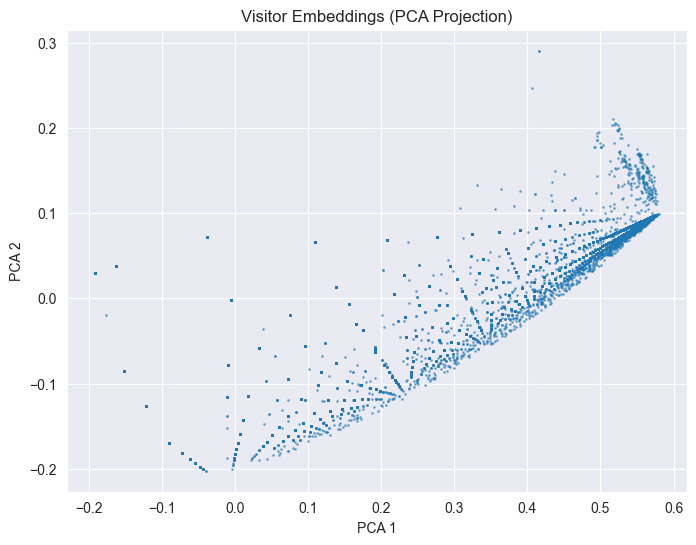

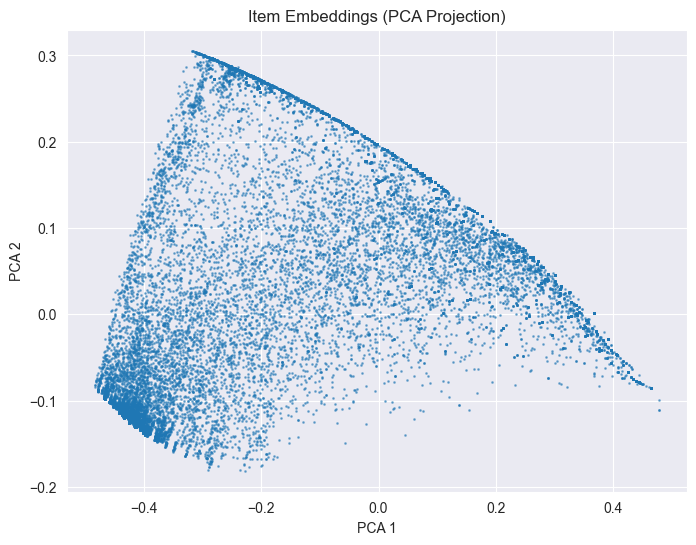

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_embeddings(embeddings, title="Embeddings Visualization"):
    embeddings_np = embeddings.detach().cpu().numpy() if isinstance(embeddings, torch.Tensor) else embeddings
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings_np)

    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=1, alpha=0.5)
    plt.title(title)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.show()

# Plot visitor and item embeddings separately
plot_embeddings(visitor_embeddings, title="Visitor Embeddings (PCA Projection)")
plot_embeddings(item_embeddings, title="Item Embeddings (PCA Projection)")


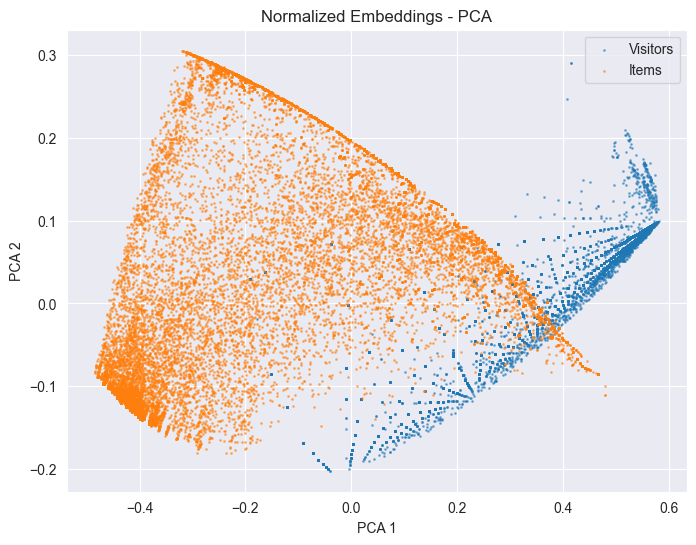

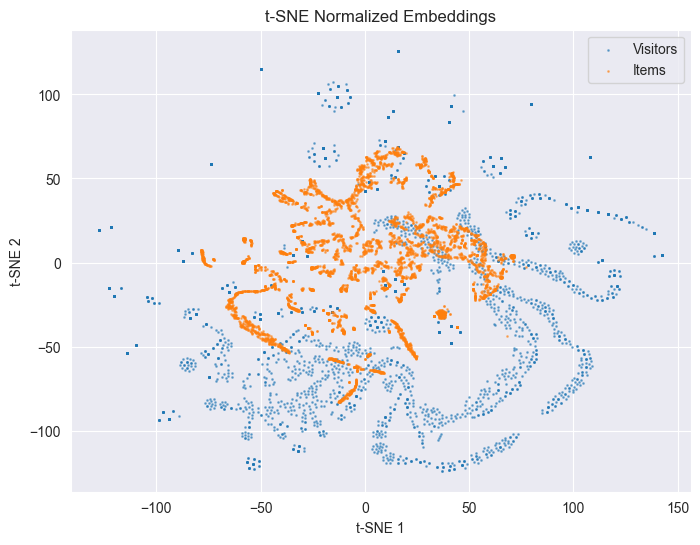

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch.nn.functional as F

# Convert tensors to numpy
visitor_embeddings_np = visitor_embeddings.cpu().detach().numpy()
item_embeddings_np = item_embeddings.cpu().detach().numpy()

# Normalize embeddings
visitor_embeddings_np = F.normalize(torch.tensor(visitor_embeddings_np), p=2, dim=1).numpy()
item_embeddings_np = F.normalize(torch.tensor(item_embeddings_np), p=2, dim=1).numpy()

### 1. PCA on Normalized Embeddings ###
pca = PCA(n_components=2)
visitor_pca_norm = pca.fit_transform(visitor_embeddings_np)
item_pca_norm = pca.fit_transform(item_embeddings_np)

# Plot Normalized PCA embeddings
plt.figure(figsize=(8,6))
plt.scatter(visitor_pca_norm[:, 0], visitor_pca_norm[:, 1], s=1, alpha=0.5, label="Visitors")
plt.scatter(item_pca_norm[:, 0], item_pca_norm[:, 1], s=1, alpha=0.5, label="Items")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Normalized Embeddings - PCA")
plt.legend()
plt.show()

### 2. t-SNE on Normalized Embeddings ###
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
visitor_tsne_norm = tsne.fit_transform(visitor_embeddings_np[:5000])  # Subsample if needed
item_tsne_norm = tsne.fit_transform(item_embeddings_np[:5000])

# Plot t-SNE Normalized embeddings
plt.figure(figsize=(8,6))
plt.scatter(visitor_tsne_norm[:, 0], visitor_tsne_norm[:, 1], s=1, alpha=0.5, label="Visitors")
plt.scatter(item_tsne_norm[:, 0], item_tsne_norm[:, 1], s=1, alpha=0.5, label="Items")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE Normalized Embeddings")
plt.legend()
plt.show()


In [ ]:
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def check_item_similarity(item_embeddings, item_indices):
    item_subset = item_embeddings[item_indices].detach().cpu().numpy()  # ✅ FIX: Use .detach()
    similarity_matrix = cosine_similarity(item_subset)
    return similarity_matrix

# Example: Check similarity for 10 random items
random_items = np.random.choice(item_embeddings.shape[0], size=10, replace=False)
similarities = check_item_similarity(item_embeddings, random_items)

print("Item Similarity Matrix:\n", similarities)


Item Similarity Matrix:
 [[1.0000001  0.6330309  0.97971314 1.0000001  1.0000001  0.90056324
  0.6003709  0.6225682  1.0000001  0.94481236]
 [0.6330309  1.0000001  0.7065571  0.6330309  0.6330309  0.8587833
  0.99528843 0.99328774 0.6330309  0.7971296 ]
 [0.97971314 0.7065571  1.0000001  0.97971314 0.97971314 0.9424705
  0.67039865 0.6952199  0.97971314 0.9862287 ]
 [1.0000001  0.6330309  0.97971314 1.0000001  1.0000001  0.90056324
  0.6003709  0.6225682  1.0000001  0.94481236]
 [1.0000001  0.6330309  0.97971314 1.0000001  1.0000001  0.90056324
  0.6003709  0.6225682  1.0000001  0.94481236]
 [0.90056324 0.8587833  0.9424705  0.90056324 0.90056324 1.
  0.8450852  0.86766505 0.90056324 0.97799206]
 [0.6003709  0.99528843 0.67039865 0.6003709  0.6003709  0.8450852
  1.0000001  0.9967454  0.6003709  0.7674288 ]
 [0.6225682  0.99328774 0.6952199  0.6225682  0.6225682  0.86766505
  0.9967454  1.         0.6225682  0.79212433]
 [1.0000001  0.6330309  0.97971314 1.0000001  1.0000001  0.9005632

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def visitor_item_similarity(visitor_embeddings, item_embeddings, visitor_indices, item_indices):
    visitor_subset = visitor_embeddings[visitor_indices].detach().cpu().numpy()
    item_subset = item_embeddings[item_indices].detach().cpu().numpy()

    similarity = cosine_similarity(visitor_subset, item_subset)
    return similarity

# Example: Check similarity for 10 visitors with 10 random items
random_visitors = np.random.choice(visitor_embeddings.shape[0], size=10, replace=False)
random_items = np.random.choice(item_embeddings.shape[0], size=10, replace=False)

visitor_item_sim = visitor_item_similarity(visitor_embeddings, item_embeddings, random_visitors, random_items)
print("Visitor-Item Similarity Matrix:\n", visitor_item_sim)


Visitor-Item Similarity Matrix:
 [[-0.5752482  -0.47216356 -0.47669354 -0.49299112 -0.49299112 -0.30071217
  -0.35862646 -0.3416659  -0.49299112 -0.39469385]
 [-0.666638   -0.56888455 -0.5752806  -0.5924648  -0.5924648  -0.32269517
  -0.3752119  -0.35635123 -0.5924648  -0.46668202]
 [-0.666638   -0.56888455 -0.5752806  -0.5924648  -0.5924648  -0.32269517
  -0.3752119  -0.35635123 -0.5924648  -0.46668202]
 [-0.6253856  -0.5340288  -0.5420126  -0.5799822  -0.5799822  -0.24606152
  -0.29375947 -0.2764928  -0.5799822  -0.4237093 ]
 [-0.6253856  -0.5340288  -0.5420126  -0.5799822  -0.5799822  -0.24606152
  -0.29375947 -0.2764928  -0.5799822  -0.4237093 ]
 [-0.666638   -0.56888455 -0.5752806  -0.5924648  -0.5924648  -0.32269517
  -0.3752119  -0.35635123 -0.5924648  -0.46668202]
 [-0.5752482  -0.47216356 -0.47669354 -0.49299112 -0.49299112 -0.30071217
  -0.35862646 -0.3416659  -0.49299112 -0.39469385]
 [-0.6253856  -0.5340288  -0.5420126  -0.5799822  -0.5799822  -0.24606152
  -0.29375947 -0.2

In [ ]:
import numpy as np

def mean_squared_error(train_data, top_k_indices, visitor_to_index):
    squared_errors = []

    for _, row in train_data.iterrows():
        visitor_id = row['visitorid']  # Get visitor ID for this row
        true_item = row['itemid']  # True interacted item
        true_event_encoded = row['event_encoded']  # Interaction type (1, 2, 3)

        # Get the index of the visitor in the graph
        if visitor_id in visitor_to_index:
            visitor_idx = visitor_to_index[visitor_id]
        else:
            print(f"Skipping visitor {visitor_id} as it is not found in the visitor_to_index.")
            continue

        # Get recommended items for this visitor from top_k_indices
        recommended_items = top_k_indices[visitor_idx].cpu().numpy()

        # Assign squared error: 0 if found, (1, 2, or 3)² if not found
        if true_item in recommended_items:
            squared_errors.append(0)
        else:
            squared_errors.append(true_event_encoded ** 2)

    return np.mean(squared_errors)

def weighted_hit_rate(train_data, top_k_indices, visitor_to_index):
    weighted_hits = 0
    total_weight = 0

    for _, row in train_data.iterrows():
        visitor_id = row['visitorid']  # Get visitor ID for this row
        true_item = row['itemid']
        true_event_encoded = row['event_encoded']

        # Get the index of the visitor in the graph
        if visitor_id in visitor_to_index:
            visitor_idx = visitor_to_index[visitor_id]
        else:
            print(f"Skipping visitor {visitor_id} as it is not found in the visitor_to_index.")
            continue

        # Get recommended items for this visitor from top_k_indices
        recommended_items = top_k_indices[visitor_idx].cpu().numpy()

        # Calculate the weight for the interaction type (3 for transaction, 2 for add-to-cart, 1 for view)
        weight = true_event_encoded
        total_weight += weight

        if true_item in recommended_items:
            weighted_hits += weight

    return weighted_hits / total_weight

# Assuming you have the visitor-to-index mapping
visitor_to_index = {v: i for i, v in enumerate(sorted(train_data['visitorid'].unique()))}

# Compute MSE and WHR on Train Data
mse_score = mean_squared_error(train_data, top_k_indices, visitor_to_index)
whr_score = weighted_hit_rate(train_data, top_k_indices, visitor_to_index)

print(f"Mean Squared Error (MSE) on Training Data: {mse_score:.4f}")
print(f"Weighted Hit Rate (WHR) on Training Data: {whr_score:.4f}")


Mean Squared Error (MSE) on Training Data: 1.2218
Weighted Hit Rate (WHR) on Training Data: 0.0000


In [ ]:
import torch_geometric, torch_sparse, torch_scatter
print(torch_geometric.__version__)
print(torch_sparse.__version__)
print(torch_scatter.__version__)

2.6.1
0.6.18
2.1.2


In [ ]:
'''# Ensure that the visitor node is handled correctly in the HANConv
# Assuming you are using an Heterogeneous Graph Neural Network (HGNN) model
output = model(x_dict, edge_index_dict)

# Inspect the output to confirm the embeddings for 'visitor' are calculated
print(f"Output embeddings for 'visitor': {output['visitor']}")
'''

=== Forward Pass Debugging ===
x_dict keys: dict_keys(['visitor', 'item', 'category'])

edge_index_dict keys: dict_keys([('visitor', 'interaction', 'item'), ('item', 'belongs_to', 'category'), ('category', 'sub_category_of', 'category'), ('visitor', 'visitor-category', 'category'), ('item', 'belongs_to_parent', 'category')])
('visitor', 'interaction', 'item'): torch.Size([2, 980286])
('item', 'belongs_to', 'category'): torch.Size([2, 30429])
('category', 'sub_category_of', 'category'): torch.Size([2, 849])
('visitor', 'visitor-category', 'category'): torch.Size([2, 980286])
('item', 'belongs_to_parent', 'category'): torch.Size([2, 30429])
✅ Found ('visitor', 'interaction', 'item') edges: torch.Size([2, 980286])

=== HANConv Output ===
{'visitor': None, 'item': tensor([[ 0.0000, 11.3224,  1.1874,  ..., 11.7579,  2.9124, 11.5879],
        [ 0.0000,  0.4071,  0.2735,  ...,  1.6497,  0.0000,  1.2548],
        [ 0.0000,  0.7065,  0.0000,  ...,  1.5973,  0.0000,  1.2018],
        ...,
      

In [ ]:
'''# Training Loop for HGT Model
def train_hgt_model(model, train_data, optimizer, criterion, num_epochs=100):
    model.train()

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # Forward pass: Get interaction scores
        output = model(train_data)  # Output interaction scores (visitor, item) pair

        # Flatten the output and actual interactions
        interaction_scores = output.view(-1)
        actual_interactions = train_data['interaction_labels'].view(-1)  # Ground truth

        # Calculate loss (Mean Squared Error for interaction prediction)
        loss = criterion(interaction_scores, actual_interactions)

        loss.backward()
        optimizer.step()

        print(f'Epoch {epoch}, Loss: {loss.item()}')

    return model


# Prepare your data (train_data in HeteroData format)
# Assuming the 'train_data' has all the required node features, edge indices, and edge attributes.

metadata = {
    'node_types': ['visitor', 'item', 'category'],  # Adjust according to your dataset
    'edge_types': [
        ('visitor', 'interaction', 'item'),
        ('item', 'belongs_to', 'category'),
        ('category', 'sub_category_of', 'category'),
        ('visitor', 'visitor-category', 'category'),
        ('item', 'belongs_to_parent', 'category')
    ]
}

# Initialize the model, optimizer, and loss function
model = HGTRecommendationModel(hidden_channels=64, num_classes=1, metadata=metadata)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()  # You can experiment with ranking losses if needed

# Train the model
train_hgt_model(model, train_data, optimizer, criterion, num_epochs=100)'''

"# Training Loop for HGT Model\ndef train_hgt_model(model, train_data, optimizer, criterion, num_epochs=100):\n    model.train()\n\n    for epoch in range(num_epochs):\n        optimizer.zero_grad()\n\n        # Forward pass: Get interaction scores\n        output = model(train_data)  # Output interaction scores (visitor, item) pair\n\n        # Flatten the output and actual interactions\n        interaction_scores = output.view(-1)\n        actual_interactions = train_data['interaction_labels'].view(-1)  # Ground truth\n\n        # Calculate loss (Mean Squared Error for interaction prediction)\n        loss = criterion(interaction_scores, actual_interactions)\n\n        loss.backward()\n        optimizer.step()\n\n        print(f'Epoch {epoch}, Loss: {loss.item()}')\n\n    return model\n\n\n# Prepare your data (train_data in HeteroData format)\n# Assuming the 'train_data' has all the required node features, edge indices, and edge attributes.\n\nmetadata = {\n    'node_types': ['visito

In [ ]:
import torch
import torch_geometric
import torch_sparse
import torch_scatter

print(torch.__version__)
print(torch_geometric.__version__)
print(torch_sparse.__version__)
print(torch_scatter.__version__)


2.6.0+cpu
2.6.1
0.6.18
2.1.2


In [ ]:
class MyModel(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MyModel, self).__init__()

        print(f"Initializing model with in_channels={in_channels}, out_channels={out_channels}")

        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, batch):
        print("Batch structure:")
        for key, x in batch.x_dict.items():
            print(f"{key} feature shape: {x.shape}")

        # Ensure the node type exists in batch
        if 'visitor' not in batch.x_dict:
            print("Skipping batch: 'visitor' node type missing.")
            return None

        x_visitor = batch.x_dict['visitor']
        print(f"x_visitor shape before Linear: {x_visitor.shape}")

        # Ensure input shape matches the linear layer
        try:
            x_visitor = self.lin(x_visitor)
            print(f"x_visitor shape after Linear: {x_visitor.shape}")
        except Exception as e:
            print(f"Error in Linear layer: {e}")
            return None

        return x_visitor  # Modify this according to your actual model


In [ ]:
'''# Retrieve the feature size dynamically (from one batch)
sample_batch = next(iter(train_loader))
visitor_feature_size = sample_batch.x_dict['visitor'].shape[1]  # Should be 3 based on error log

# Initialize the model with correct input size
model = MyModel(in_channels=visitor_feature_size, out_channels=64).to(device)
'''

"# Retrieve the feature size dynamically (from one batch)\nsample_batch = next(iter(train_loader))\nvisitor_feature_size = sample_batch.x_dict['visitor'].shape[1]  # Should be 3 based on error log\n\n# Initialize the model with correct input size\nmodel = MyModel(in_channels=visitor_feature_size, out_channels=64).to(device)\n"

In [ ]:
'''device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(1, 201):
    model.train()
    total_loss = 0
    missing_event_count = 0  # Counter for batches missing 'event_encoded'

    for batch_idx, batch in enumerate(train_loader):
        if batch_idx % 100 == 0:  # Reduce excessive logging
            print(f"\n[Batch {batch_idx + 1}] Processing...")

        # Move batch to device
        try:
            batch = batch.to(device)
        except Exception as e:
            print(f"Error moving batch to device: {e}")
            continue

        optimizer.zero_grad()

        # Ensure 'visitor' node has features
        if 'visitor' not in batch.x_dict or batch.x_dict['visitor'].shape[0] == 0:
            continue  # Skip empty visitor node batches

        try:
            out = model(batch)
            if out is None:
                continue  # Skip if model output is None
        except Exception as e:
            print(f"Error in model forward pass: {e}")
            continue

        # Check if 'event_encoded' exists
        if not hasattr(batch, 'event_encoded') or batch.event_encoded is None:
            missing_event_count += 1  # Increment missing label counter
            continue  # Continue training without skipping the epoch

        try:
            event_encoded = batch.event_encoded.to(device)

            # Convert one-hot encoded target to class indices if needed
            if event_encoded.ndimension() > 1:
                event_encoded = event_encoded.argmax(dim=1)

        except Exception as e:
            print(f"Error processing event_encoded: {e}")
            continue

        # Ensure output and target shapes are compatible
        if out.shape[0] != event_encoded.shape[0]:
            if batch_idx % 100 == 0:
                print(f"Shape mismatch: out={out.shape}, event_encoded={event_encoded.shape}, skipping batch.")
            continue

        # Compute loss
        try:
            loss = torch.nn.CrossEntropyLoss()(out, event_encoded)
        except Exception as e:
            print(f"Error computing loss: {e}")
            continue

        # Backpropagation
        try:
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        except Exception as e:
            print(f"Error in backpropagation: {e}")
            continue

    print(f"Epoch {epoch} Summary: Loss: {total_loss / len(train_loader):.4f}, Missing event_encoded: {missing_event_count}/{len(train_loader)}")'''


'device = torch.device(\'cuda\' if torch.cuda.is_available() else \'cpu\')\nmodel.to(device)\n\nfor epoch in range(1, 201):\n    model.train()\n    total_loss = 0\n    missing_event_count = 0  # Counter for batches missing \'event_encoded\'\n\n    for batch_idx, batch in enumerate(train_loader):\n        if batch_idx % 100 == 0:  # Reduce excessive logging\n            print(f"\n[Batch {batch_idx + 1}] Processing...")\n\n        # Move batch to device\n        try:\n            batch = batch.to(device)\n        except Exception as e:\n            print(f"Error moving batch to device: {e}")\n            continue\n\n        optimizer.zero_grad()\n\n        # Ensure \'visitor\' node has features\n        if \'visitor\' not in batch.x_dict or batch.x_dict[\'visitor\'].shape[0] == 0:\n            continue  # Skip empty visitor node batches\n\n        try:\n            out = model(batch)\n            if out is None:\n                continue  # Skip if model output is None\n        except Ex